In [1]:
import pandas as pd
import numpy as np
house_df = pd.read_csv('./data/Ames_Housing_Price_Data.csv',index_col = 0)
real_estate_df = pd.read_csv('./data/Ames_Real_Estate_Data.csv', index_col = 0, low_memory= False).reset_index()

### Objective

Business Intelligence for the Home Builder/Flipper: A new home builder/old house remodeler would like to get into building new homes or flipping older houses for profit. Based on your modeling result, provide insights for your client. This is a more difficult question because it is hard to estimate building costs.

Descriptive side:
- Where/when houses sold
- Differences in neighborhoods (groupby ...)
- 

This will feed in to the model below

Predictive side:
- Model predicts house prices based on several factors to indentify houses to buy, improve and sell
    - How much more is a house worth if it was newer?
    - Had a second floor, more area, pool, garage, etc. 

Feature Engineering Ideas:
- knn with lat/long coords as neighborhoods
    need to add lat/long
- unsupervised clustering to look at similar houses, maybe supervised with 
- PCA or linear regression on categories
- Just basic linear regression
- Just cut the dataset down and do a quick linear regression
    


### Baseline Linear Regression Model:

Building a linear regression model using a small amount of columns which, from a quick glance should be important. With and without normalizing to be able to judge relative coefficients.


In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lm_base = LinearRegression()

house_base = house_df.loc[:,['GrLivArea','SalePrice','LotArea','Street','Neighborhood','Condition1',
                      'HouseStyle','OverallQual','OverallCond','RoofStyle','YearBuilt','YearRemodAdd',
                      'Exterior1st','Foundation','TotalBsmtSF','Fireplaces','GarageArea','PoolArea',
                      'MoSold','YrSold','SaleCondition','SaleType']]

house_base = pd.get_dummies(house_base) #one hot encode
house_base = house_base.drop(['SaleType_WD ','SaleCondition_Abnorml','Foundation_Wood',
                             'Exterior1st_WdShing','Neighborhood_Landmrk','Street_Grvl',
                             'RoofStyle_Shed','HouseStyle_2.5Fin'], axis = 1) #drop some categorical columns
#Think about automating above function

In [67]:
house_base = house_base.drop(913, axis = 0)

In [68]:
house_base.GarageArea[np.isnan(house_base.GarageArea)] = 0 #fix to avoid copying issue

In [72]:
x_train, x_test, y_train, y_test = train_test_split(house_base.drop('SalePrice', axis = 1),house_base['SalePrice'],test_size = .2, random_state = 42)

lm_base.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
lm_base.score(x_train, y_train)

0.8761285655133221

In [74]:
lm_base.score(x_test, y_test)

0.8624379348243185

Not bad! Let's look at coefficents and use the statsmodels package to dive into the statistics. 

In [88]:
pd.Series(dict(zip(list(x_train.columns),lm_base.coef_)))

GrLivArea            52.185337
LotArea               0.631608
OverallQual       12006.800977
OverallCond        7283.749274
YearBuilt           323.102680
                      ...     
SaleType_ConLI    -3969.212208
SaleType_ConLw     7504.764536
SaleType_New     -25992.195864
SaleType_Oth      -9360.846599
SaleType_VWD      -5023.836242
Length: 94, dtype: float64

In [87]:
import statsmodels.api as sm
x = sm.add_constant(x_train)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     149.7
Date:                Tue, 25 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:39:33   Log-Likelihood:                -23945.
No. Observations:                2063   AIC:                         4.808e+04
Df Residuals:                    1969   BIC:                         4.861e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -6.927e+

Lots of high p values and small eigenvalues, lets drop more columns. Neighborhood,foundation, saletype, salecondition, exterior, housestyle, condition1, street_pave. Make age column and replace yearbuild. Also taking a deeper look at correlations:

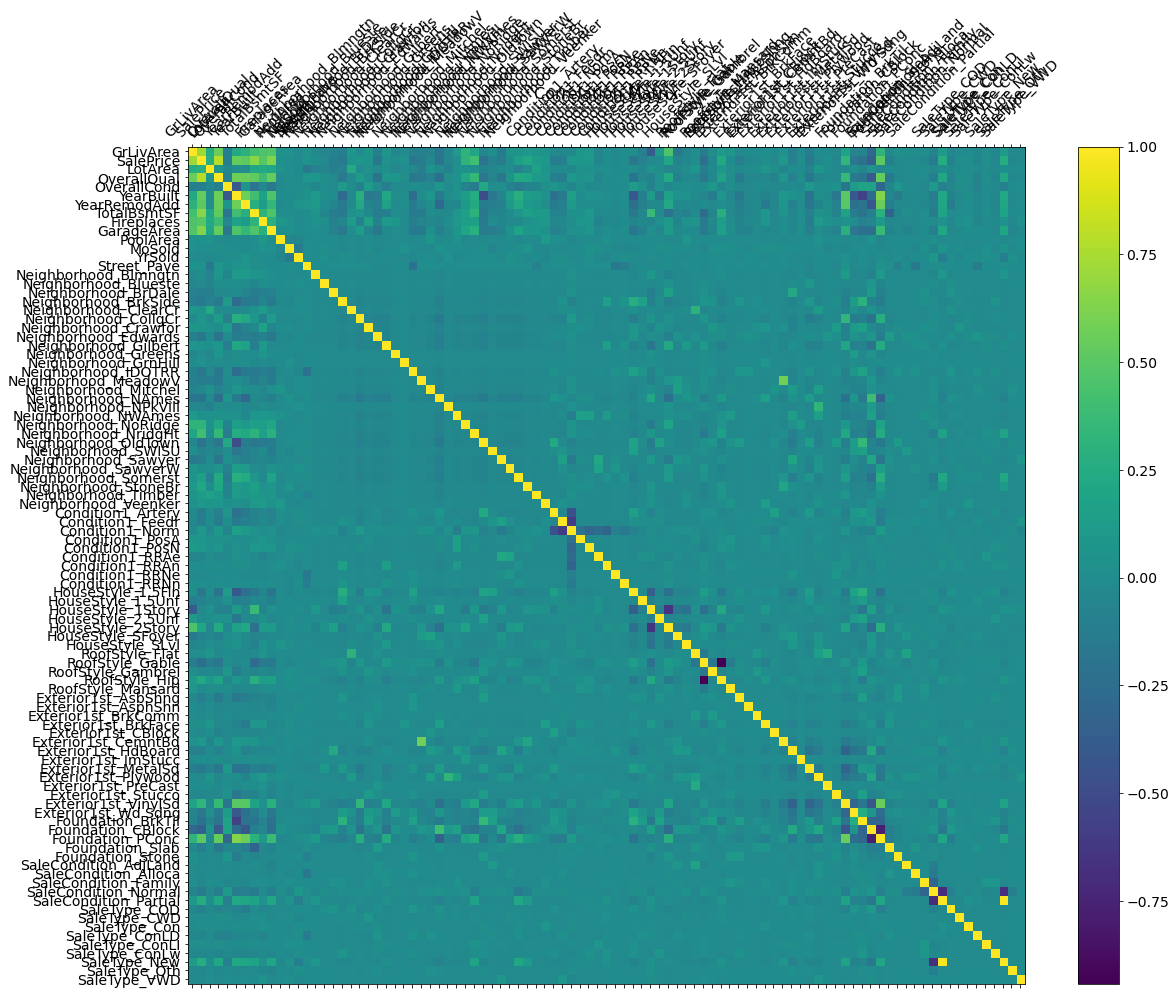

In [91]:
import matplotlib.pyplot as plt


f = plt.figure(figsize=(19, 15))
plt.matshow(house_base.corr(), fignum=f.number)
plt.xticks(range(house_base.shape[1]), house_base.columns, fontsize=14, rotation=45)
plt.yticks(range(house_base.shape[1]), house_base.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

Not obviously horrible. Most of the bivariate covariance seems to be at the top.  

In [120]:
house_base_reduced = house_df.loc[:,['GrLivArea','SalePrice','LotArea',
                      'OverallQual','OverallCond','RoofStyle','YearBuilt','YearRemodAdd',
                      'TotalBsmtSF','Fireplaces','GarageArea',
                      'MoSold','YrSold']]
house_base_reduced = pd.get_dummies(house_base_reduced)

house_base_reduced['Age'] = house_base_reduced['YrSold'] - house_base_reduced['YearBuilt']
house_base_reduced['YrSinceRemod'] =  house_base_reduced['YrSold'] - house_base_reduced['YearRemodAdd']
house_base_reduced = house_base_reduced.drop(['YrSold','YearBuilt','YearRemodAdd'],axis = 1)

In [121]:
house_base_reduced = house_base_reduced.drop(913, axis = 0)
house_base_reduced.GarageArea[np.isnan(house_base_reduced.GarageArea)] = 0 #fix to avoid copying issue

In [122]:
lm_base_reduced = LinearRegression()
xr_train, xr_test, yr_train, yr_test = train_test_split(house_base_reduced.drop('SalePrice', axis = 1),house_base_reduced['SalePrice'],test_size = .2, random_state = 42)


In [123]:
lm_base_reduced.fit(xr_train, yr_train)

print(lm_base_reduced.score(xr_test, yr_test))
print(lm_base_reduced.score(xr_train, yr_train))

0.826719439274574
0.8376321159862207


In [124]:
x = sm.add_constant(xr_train)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(yr_train, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     704.0
Date:                Tue, 25 Aug 2020   Prob (F-statistic):               0.00
Time:                        22:04:56   Log-Likelihood:                -24225.
No. Observations:                2063   AIC:                         4.848e+04
Df Residuals:                    2047   BIC:                         4.857e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -5.256e+04   6504.12

Unsurprisingly does a bit worse. Just less features to fit the residuals and still lots of multi collinearity. GrLivArea highly correlated with OverallQual, Fireplaces and GarageArea.

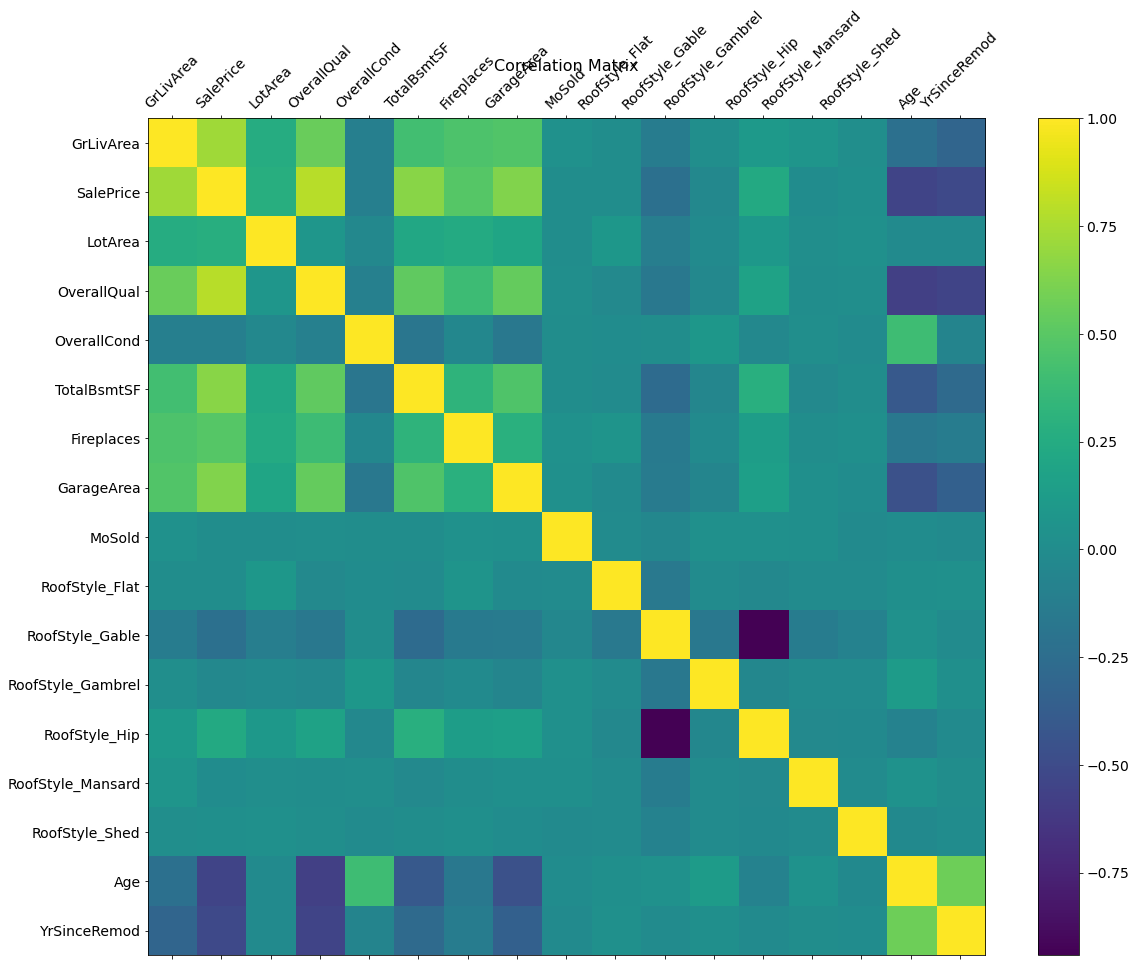

In [125]:
f = plt.figure(figsize=(19, 15))
plt.matshow(house_base_reduced.corr(), fignum=f.number)
plt.xticks(range(house_base_reduced.shape[1]), house_base_reduced.columns, fontsize=14, rotation=45)
plt.yticks(range(house_base_reduced.shape[1]), house_base_reduced.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

Adding lat long coordinates for a neighborhood analysis:

In [133]:
df = house_df.merge(real_estate_df[['MapRefNo','Prop_Addr']],how='left', left_on = 'PID', right_on = 'MapRefNo')
df = df.drop([x for x in df.columns if ('_y' in x)], axis = 1)

In [135]:
from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent="myGeocoder")

In [138]:
geocode = RateLimiter(locator.geocode, min_delay_seconds=.05)
locations = [geocode(addr+', Ames, USA') if type(addr)==str else None for addr in df.Prop_Addr]

In [157]:
#have to unpack location lat and long into the df. Then save it!!!
latlong = [[x.latitude, x.longitude] if x != None else [None,None] for x in locations]

In [165]:
df['latitude'] = [x.latitude if x != None else None for x in locations]
df['longitude'] = [x.longitude if x != None else None for x in locations]

In [169]:
df.to_pickle('./pickles/house_latlong.p')